# Denoising Autoencoder
Build a stacked denoising autoencoder to work on fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

May also try a denoising convolutional autoencoder.

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


Left align tables:

In [2]:
%%html
<style>
table {float:left}
</style>

## 1.0 Load and Prepare Data

In [3]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# check the shape of the data sets
print('X_train_full shape:', X_train_all.shape)
print('y_train_full shape:', y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
# split the data between train and validation sets, and scale

X_valid, X_train = X_train_all[:5000] / 255.0, X_train_all[5000:] / 255.0
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_valid shape: (5000, 28, 28)
y_valid shape: (5000,)
X_train shape: (55000, 28, 28)
y_train shape: (55000,)


## 2.0 Stacked Denoising Autoencoder

Build a stacked denoising autoencoder.

This is a simple stacked autoencoder, except that noise is added at the first layer.

First, we will define the "rounded accuracy" metric. Geron, in his book, says that "you might be tempted to use the accuracy metric, but it would not work properly, since this metric expects the labels to be either 0 or 1 for each pixel. You can easily work around this problem by creating a custom metric that computes the accuracy after rounding the targets and predictions to 0 or 1."

In [14]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),metrics=[rounded_accuracy])

denoising_encoder.summary()
denoising_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_13 (Dense)             (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               3100      
___________________________

In [16]:
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3504 - rounded_accuracy: 0.8771 - val_loss: 0.3118 - val_rounded_accuracy: 0.9101
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3120 - rounded_accuracy: 0.9100 - val_loss: 0.3039 - val_rounded_accuracy: 0.9163
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3056 - rounded_accuracy: 0.9155 - val_loss: 0.2995 - val_rounded_accuracy: 0.9181
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3022 - rounded_accuracy: 0.9185 - val_loss: 0.2959 - val_rounded_accuracy: 0.9231
Epoch 5/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.2998 - rounded_accuracy: 0.9206 - val_loss: 0.2932 - val_rounded_accuracy: 0.9256
Epoch 6/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.2978 - rounded_accuracy: 0.9222 - val_loss:

In [20]:
def plot_reconstructions(model, index_list, X_valid):
    """Plot some original images, and their reconstructions
    
    Parameters
    ===========
    model : keras model
        Autoencoder model
        
    index_list : list
        List of indices. These indices correspond to the index of the X_valid images
        that will be shown
        
    X_valid : numpy array
        X_valid set

    """
    
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

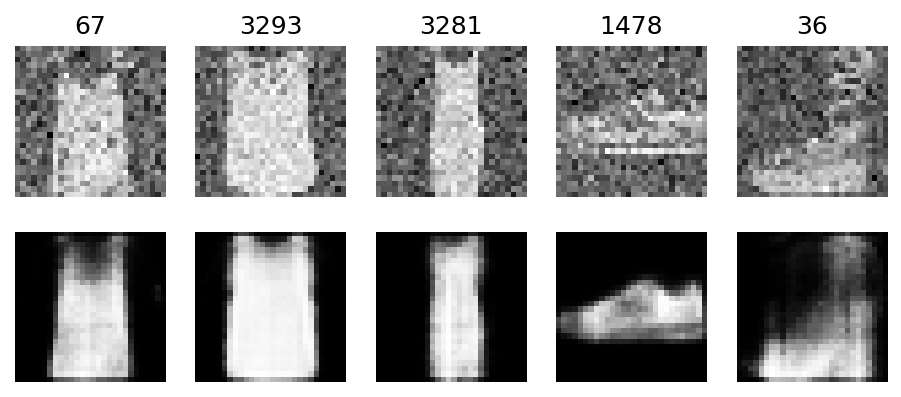

In [21]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_valid)), 5)

# add in noise to the images with keras Gaussian Noise layer
noise = keras.layers.GaussianNoise(0.2, dtype='float32')

plot_reconstructions(denoising_ae, index_list, noise(X_valid, training=True))

Now we will add dropout for the first layer.

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])

dropout_encoder.summary()
dropout_decoder.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_21 (Dense)             (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 100)               3100      
__________________________

In [24]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3566 - rounded_accuracy: 0.8712 - val_loss: 0.3159 - val_rounded_accuracy: 0.9027
Epoch 2/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3185 - rounded_accuracy: 0.9033 - val_loss: 0.3072 - val_rounded_accuracy: 0.9121
Epoch 3/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3129 - rounded_accuracy: 0.9077 - val_loss: 0.3035 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3094 - rounded_accuracy: 0.9105 - val_loss: 0.3001 - val_rounded_accuracy: 0.9186
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3069 - rounded_accuracy: 0.9125 - val_loss: 0.2978 - val_rounded_accuracy: 0.9198
Epoch 6/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3051 - rounded_accuracy: 0.9139 - val_loss:

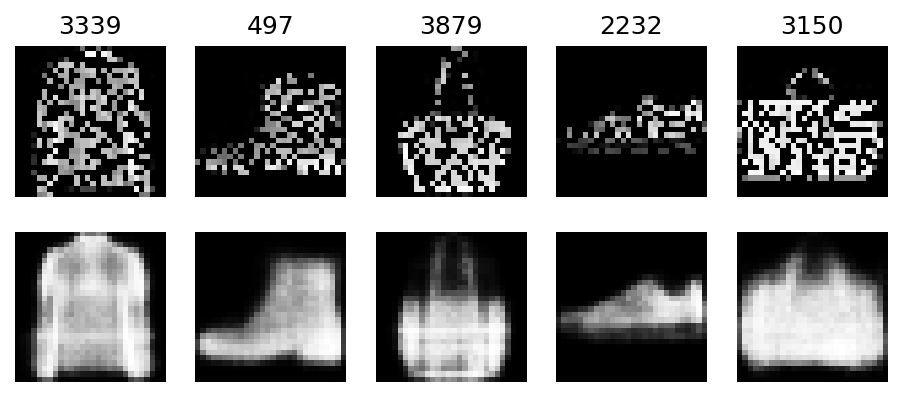

In [26]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_valid)), 5)

# add dropout to the images with keras dropout layer
dropout = keras.layers.Dropout(0.5, dtype='float32')

plot_reconstructions(denoising_ae, index_list, dropout(X_valid, training=True))

## Denoising Convolutional Autoencoder
Build a denoising convolutional autoencoder.

In [29]:
tf.random.set_seed(32)
np.random.seed(32)

noise_conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
noise_conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
noise_conv_ae = keras.models.Sequential([noise_conv_encoder, noise_conv_decoder])

noise_conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),metrics=[rounded_accuracy])

noise_conv_encoder.summary()
noise_conv_decoder.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
gaussian_noise_11 (GaussianN (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)        

In [30]:
history = noise_conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 11s 195us/sample - loss: 0.2993 - rounded_accuracy: 0.9239 - val_loss: 0.2774 - val_rounded_accuracy: 0.9411
Epoch 2/5
55000/55000 [==============================] - 9s 156us/sample - loss: 0.2780 - rounded_accuracy: 0.9408 - val_loss: 0.2703 - val_rounded_accuracy: 0.9482
Epoch 3/5
55000/55000 [==============================] - 9s 156us/sample - loss: 0.2739 - rounded_accuracy: 0.9449 - val_loss: 0.2664 - val_rounded_accuracy: 0.9514
Epoch 4/5
55000/55000 [==============================] - 9s 156us/sample - loss: 0.2717 - rounded_accuracy: 0.9472 - val_loss: 0.2670 - val_rounded_accuracy: 0.9513
Epoch 5/5
55000/55000 [==============================] - 9s 157us/sample - loss: 0.2704 - rounded_accuracy: 0.9486 - val_loss: 0.2635 - val_rounded_accuracy: 0.9547


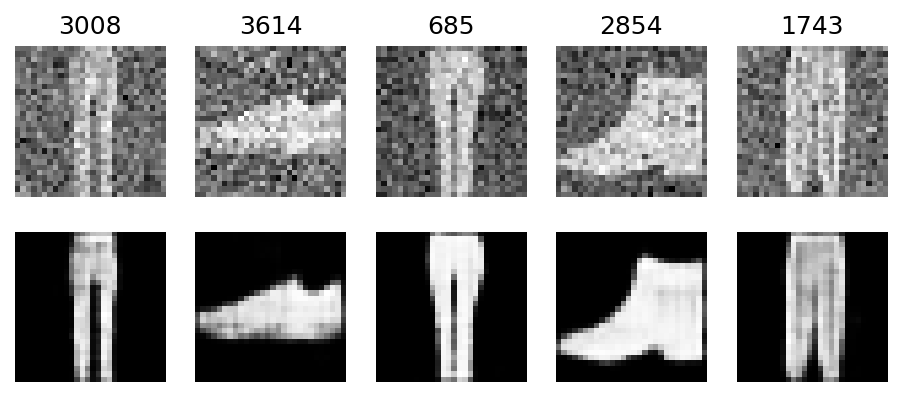

In [31]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_valid)), 5)

# add in noise to the images with keras Gaussian Noise layer
noise = keras.layers.GaussianNoise(0.2, dtype='float32')

plot_reconstructions(noise_conv_ae, index_list, noise(X_valid, training=True))

Lets compare the results from the denoising stacked autoencoder, and the denoising convolutional autoencoder.

Original Images:


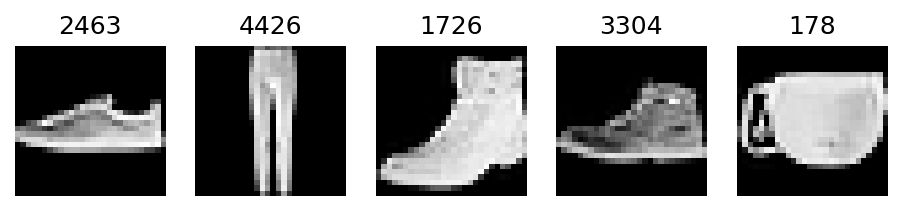

Denoising Autoencoder: 


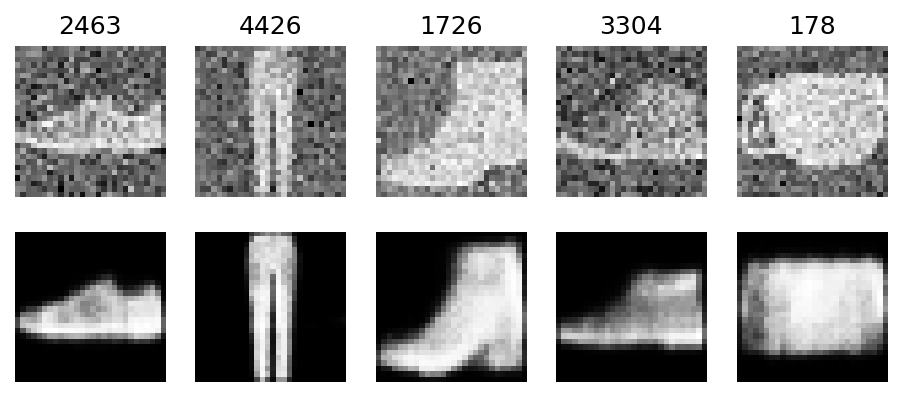

Denoising Convoluional Autoencoder: 


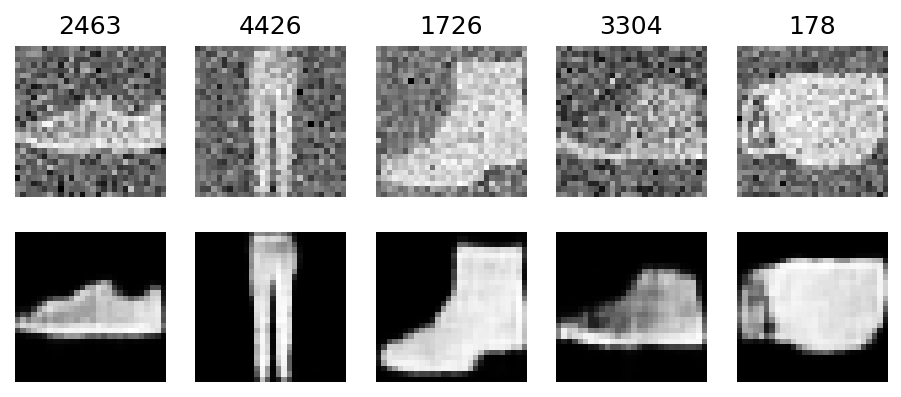

In [43]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_valid)), 5)

# add in noise to the images with keras Gaussian Noise layer
noise = keras.layers.GaussianNoise(0.2, dtype='float32')
data_input = noise(X_valid, training=True)



# plot original images
print("Original Images:")
n_images = len(index_list)
# Plot a random sample
fig, axes = plt.subplots(1, n_images,figsize=(n_images*1.5,3),dpi=150)

for i in range(0, n_images):
    axes[i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
    axes[i].axis('off')
    axes[i].set_title(str(index_list[i]))

plt.show()

print("Denoising Autoencoder: ")
plot_reconstructions(denoising_ae, index_list, data_input)
print("Denoising Convoluional Autoencoder: ")
plot_reconstructions(noise_conv_ae, index_list, data_input)

Denoising CAE may be slightly better.